# KC Housing Data Evaluation

In [1]:
#Import the relevant packages into notebook
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
from matplotlib.ticker import FuncFormatter
from sklearn.dummy import DummyRegressor
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_validate, ShuffleSplit
from sklearn.feature_selection import RFECV
from sklearn.preprocessing import StandardScaler

In [2]:
# Used in converting x and y axis ticks.

def millions(x, pos):
    'The two args are the value and tick position'
    return '%1.1fM' % (x * 1e-6)

formatter = FuncFormatter(millions)

Upload the data into the notebook and examine it

In [3]:
kc_house_data=pd.read_csv('data/kc_house_data.csv')

In [4]:
kc_house_data.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,7129300520,10/13/2014,221900.0,3,1.00,1180,5650,1.0,NaN,NONE,...,7 Average,1180,0.0,1955,0.0,98178,47.5112,-122.257,1340,5650
1,6414100192,12/9/2014,538000.0,3,2.25,2570,7242,2.0,NO,NONE,...,7 Average,2170,400.0,1951,1991.0,98125,47.7210,-122.319,1690,7639
2,5631500400,2/25/2015,180000.0,2,1.00,770,10000,1.0,NO,NONE,...,6 Low Average,770,0.0,1933,NaN,98028,47.7379,-122.233,2720,8062
3,2487200875,12/9/2014,604000.0,4,3.00,1960,5000,1.0,NO,NONE,...,7 Average,1050,910.0,1965,0.0,98136,47.5208,-122.393,1360,5000
4,1954400510,2/18/2015,510000.0,3,2.00,1680,8080,1.0,NO,NONE,...,8 Good,1680,0.0,1987,0.0,98074,47.6168,-122.045,1800,7503


In [5]:
kc_house_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21597 entries, 0 to 21596
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             21597 non-null  int64  
 1   date           21597 non-null  object 
 2   price          21597 non-null  float64
 3   bedrooms       21597 non-null  int64  
 4   bathrooms      21597 non-null  float64
 5   sqft_living    21597 non-null  int64  
 6   sqft_lot       21597 non-null  int64  
 7   floors         21597 non-null  float64
 8   waterfront     19221 non-null  object 
 9   view           21534 non-null  object 
 10  condition      21597 non-null  object 
 11  grade          21597 non-null  object 
 12  sqft_above     21597 non-null  int64  
 13  sqft_basement  21597 non-null  object 
 14  yr_built       21597 non-null  int64  
 15  yr_renovated   17755 non-null  float64
 16  zipcode        21597 non-null  int64  
 17  lat            21597 non-null  float64
 18  long  

In [6]:
kc_house_data.isnull().sum()

id                  0
date                0
price               0
bedrooms            0
bathrooms           0
sqft_living         0
sqft_lot            0
floors              0
waterfront       2376
view               63
condition           0
grade               0
sqft_above          0
sqft_basement       0
yr_built            0
yr_renovated     3842
zipcode             0
lat                 0
long                0
sqft_living15       0
sqft_lot15          0
dtype: int64

There appears to be three columns that have missing data. waterfront, yr_renovated and view. View is only missing 63 while the other two are missing north of 2000. We will probably look deeper but to not mess with the data too much it may make sense to drop those 63 missing view columns.

In [7]:
kc_house_data.corr()

,id,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,sqft_above,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
id,1.000000,-0.016772,0.001150,0.005162,-0.012241,-0.131911,0.018608,-0.010799,0.021617,-0.012010,-0.008211,-0.001798,0.020672,-0.002701,-0.138557
price,-0.016772,1.000000,0.308787,0.525906,0.701917,0.089876,0.256804,0.605368,0.053953,0.129599,-0.053402,0.306692,0.022036,0.585241,0.082845
bedrooms,0.001150,0.308787,1.000000,0.514508,0.578212,0.032471,0.177944,0.479386,0.155670,0.018495,-0.154092,-0.009951,0.132054,0.393406,0.030690
bathrooms,0.005162,0.525906,0.514508,1.000000,0.755758,0.088373,0.502582,0.686668,0.507173,0.051050,-0.204786,0.024280,0.224903,0.569884,0.088303
sqft_living,-0.012241,0.701917,0.578212,0.755758,1.000000,0.173453,0.353953,0.876448,0.318152,0.055660,-0.199802,0.052155,0.241214,0.756402,0.184342
sqft_lot,-0.131911,0.089876,0.032471,0.088373,0.173453,1.000000,-0.004814,0.184139,0.052946,0.004513,-0.129586,-0.085514,0.230227,0.144763,0.718204
floors,0.018608,0.256804,0.177944,0.502582,0.353953,-0.004814,1.000000,0.523989,0.489193,0.003535,-0.059541,0.049239,0.125943,0.280102,-0.010722
sqft_above,-0.010799,0.605368,0.479386,0.686668,0.876448,0.184139,0.523989,1.000000,0.424037,0.022137,-0.261570,-0.001199,0.344842,0.731767,0.195077
yr_built,0.021617,0.053953,0.155670,0.507173,0.318152,0.052946,0.489193,0.424037,1.000000,-0.225209,-0.347210,-0.148370,0.409993,0.326377,0.070777
yr_renovated,-0.012010,0.129599,0.018495,0.051050,0.055660,0.004513,0.003535,0.022137,-0.225209,1.000000,0.069846,0.032145,-0.072156,-0.000247,0.003852


In [8]:
#kc_house_data['date'] = pd.to_datetime(kc_house_data['date'])
#kc_house_data['day_sold'] = kc_house_data['date'].map(lambda x: x.day)
#kc_house_data['month_sold'] = kc_house_data['date'].map(lambda x: x.month)
#kc_house_data['year_sold'] = kc_house_data['date'].map(lambda x: x.year)
#kc_house_data.drop('date', axis=1, inplace=True)

In [9]:
#kc_house_data['waterfront']=kc_house_data['waterfront'].fillna('NO')
#kc_house_data['view']=kc_house_data['view'].fillna('NONE')
#kc_house_data['yr_renovated'].fillna(0.0, inplace=True)

In [10]:
#from sklearn.preprocessing import LabelEncoder
#X1=kc_house_data['waterfront']
#lb_make = LabelEncoder()
#origin_encoded = lb_make.fit_transform(X1)
#origin_encoded
#origin_encoded=pd.Series(origin_encoded)
#origin_encoded.value_counts()

In [11]:
#kc_house_data['waterfront']=origin_encoded


In [12]:
#from sklearn.model_selection import train_test_split
#X_new= kc_house_data.drop(['price'],axis=1)
#y_new=kc_house_data['price']
#X_train, X_test, Y_train, Y_test = train_test_split(X_new, y_new, random_state=100)

In [13]:
#linreg = LinearRegression()
#linreg.fit(X_train,Y_train)
#linreg.score(X_train,Y_train)

<AxesSubplot:>

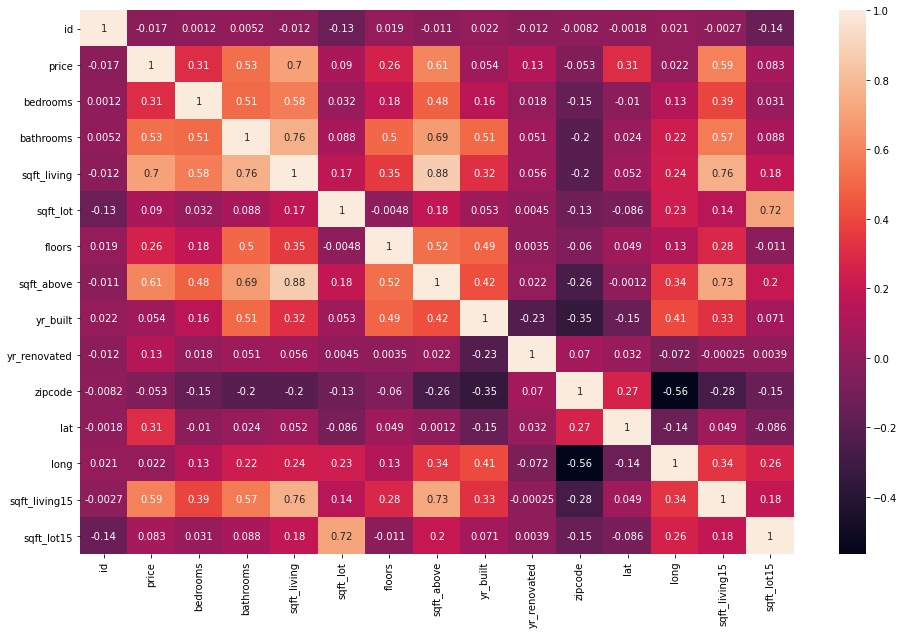

In [14]:
plt.figure(figsize=(16, 10))
sns.heatmap(data=kc_house_data.corr(), annot=True)

There seems to be something going on with correlations between price and bedrooms as well as price and bathrooms

In [15]:
X_train = kc_house_data.drop("price", axis = 1)
Y_train = kc_house_data["price"]

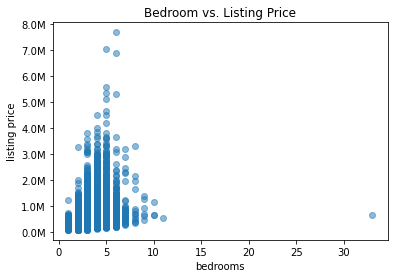

In [16]:
fig, ax = plt.subplots()

ax.yaxis.set_major_formatter(formatter)
ax.scatter(X_train["bedrooms"], Y_train, alpha=0.5)
ax.set_xlabel("bedrooms")
ax.set_ylabel("listing price")
ax.set_title("Bedroom vs. Listing Price");

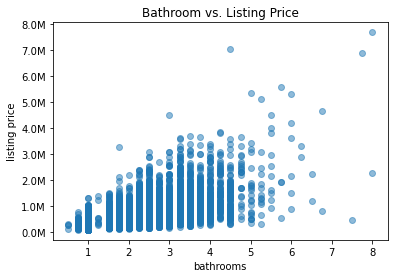

In [17]:
fig, ax = plt.subplots()

ax.yaxis.set_major_formatter(formatter)
ax.scatter(X_train["bathrooms"], Y_train, alpha=0.5)
ax.set_xlabel("bathrooms")
ax.set_ylabel("listing price")
ax.set_title("Bathroom vs. Listing Price");

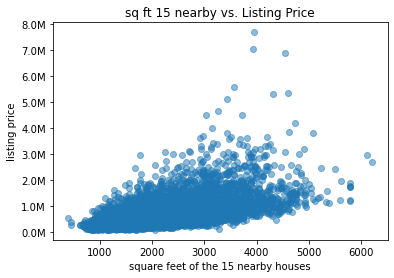

In [18]:
fig, ax = plt.subplots()

ax.yaxis.set_major_formatter(formatter)
ax.scatter(X_train["sqft_living15"], Y_train, alpha=0.5)
ax.set_xlabel("square feet of the 15 nearby houses")
ax.set_ylabel("listing price")
ax.set_title("sq ft 15 nearby vs. Listing Price");

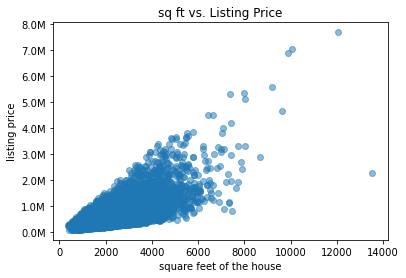

In [19]:
fig, ax = plt.subplots()

ax.yaxis.set_major_formatter(formatter)
ax.scatter(X_train["sqft_living"], Y_train, alpha=0.5)
ax.set_xlabel("square feet of the house")
ax.set_ylabel("listing price")
ax.set_title("sq ft vs. Listing Price");

In [20]:
X_train["zipcode"].value_counts()

98103    602
98038    589
98115    583
98052    574
98117    553
        ... 
98102    104
98010    100
98024     80
98148     57
98039     50
Name: zipcode, Length: 70, dtype: int64

In [21]:
zipcodes = X_train.groupby(["zipcode"])

In [22]:
zipcodes.head()

,id,date,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,7129300520,10/13/2014,3,1.00,1180,5650,1.0,NaN,NONE,Average,7 Average,1180,0.0,1955,0.0,98178,47.5112,-122.257,1340,5650
1,6414100192,12/9/2014,3,2.25,2570,7242,2.0,NO,NONE,Average,7 Average,2170,400.0,1951,1991.0,98125,47.7210,-122.319,1690,7639
2,5631500400,2/25/2015,2,1.00,770,10000,1.0,NO,NONE,Average,6 Low Average,770,0.0,1933,NaN,98028,47.7379,-122.233,2720,8062
3,2487200875,12/9/2014,4,3.00,1960,5000,1.0,NO,NONE,Very Good,7 Average,1050,910.0,1965,0.0,98136,47.5208,-122.393,1360,5000
4,1954400510,2/18/2015,3,2.00,1680,8080,1.0,NO,NONE,Average,8 Good,1680,0.0,1987,0.0,98074,47.6168,-122.045,1800,7503
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2972,3625049014,8/29/2014,4,3.50,4860,23885,2.0,NO,NONE,Average,12 Luxury,4860,0.0,1996,0.0,98039,47.6172,-122.230,3580,16054
3757,2540700110,2/12/2015,4,3.50,4210,18564,2.0,NO,NONE,Average,11 Excellent,4210,0.0,2001,0.0,98039,47.6206,-122.225,3520,18564
4073,3262300940,11/7/2014,3,1.00,1220,8119,1.0,NO,NONE,Good,7 Average,1220,0.0,1955,NaN,98039,47.6328,-122.236,1910,8119
4074,3262300940,2/10/2015,3,1.00,1220,8119,1.0,NO,NONE,Good,7 Average,1220,0.0,1955,NaN,98039,47.6328,-122.236,1910,8119


In [23]:
X_train['zipcode'].unique()
zipcodes = X_train['zipcode'].unique()
zipcodes.sort()
zipcodes

array([98001, 98002, 98003, 98004, 98005, 98006, 98007, 98008, 98010,
       98011, 98014, 98019, 98022, 98023, 98024, 98027, 98028, 98029,
       98030, 98031, 98032, 98033, 98034, 98038, 98039, 98040, 98042,
       98045, 98052, 98053, 98055, 98056, 98058, 98059, 98065, 98070,
       98072, 98074, 98075, 98077, 98092, 98102, 98103, 98105, 98106,
       98107, 98108, 98109, 98112, 98115, 98116, 98117, 98118, 98119,
       98122, 98125, 98126, 98133, 98136, 98144, 98146, 98148, 98155,
       98166, 98168, 98177, 98178, 98188, 98198, 98199], dtype=int64)

<AxesSubplot:>

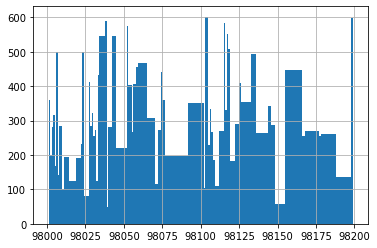

In [24]:
X_train['zipcode'].hist(bins = zipcodes)

In [25]:
baseline_model = LinearRegression()

splitter = ShuffleSplit(n_splits=3, test_size=0.25, random_state=0)

baseline_scores = cross_validate(
    estimator=baseline_model,
    X=X_train[["sqft_living"]],
    y=Y_train,
    return_train_score=True,
    cv=splitter
)

print("Train score:     ", baseline_scores["train_score"].mean())
print("Validation score:", baseline_scores["test_score"].mean())

Train score:      0.48774659364870426
Validation score: 0.5024006604207555


Because we are using the .score method of LinearRegression, these
are r-squared scores. That means that each of them represents the
amount of variance of the target (listing price) that is explained
by the model's features (currently just the square feet living space) and
parameters (intercept value and coefficient values for the features)

In general this seems like a fairly strong model already. It is
getting nearly identical performance on training subsets compared to
the validation subsets, explaining around 50% of the variance both
times

Now let's try building a model with all numeric features

In [26]:
X_train_numeric = X_train.select_dtypes("number").copy()

X_train_numeric

,id,bedrooms,bathrooms,sqft_living,sqft_lot,floors,sqft_above,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,7129300520,3,1.00,1180,5650,1.0,1180,1955,0.0,98178,47.5112,-122.257,1340,5650
1,6414100192,3,2.25,2570,7242,2.0,2170,1951,1991.0,98125,47.7210,-122.319,1690,7639
2,5631500400,2,1.00,770,10000,1.0,770,1933,NaN,98028,47.7379,-122.233,2720,8062
3,2487200875,4,3.00,1960,5000,1.0,1050,1965,0.0,98136,47.5208,-122.393,1360,5000
4,1954400510,3,2.00,1680,8080,1.0,1680,1987,0.0,98074,47.6168,-122.045,1800,7503
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21592,263000018,3,2.50,1530,1131,3.0,1530,2009,0.0,98103,47.6993,-122.346,1530,1509
21593,6600060120,4,2.50,2310,5813,2.0,2310,2014,0.0,98146,47.5107,-122.362,1830,7200
21594,1523300141,2,0.75,1020,1350,2.0,1020,2009,0.0,98144,47.5944,-122.299,1020,2007
21595,291310100,3,2.50,1600,2388,2.0,1600,2004,0.0,98027,47.5345,-122.069,1410,1287


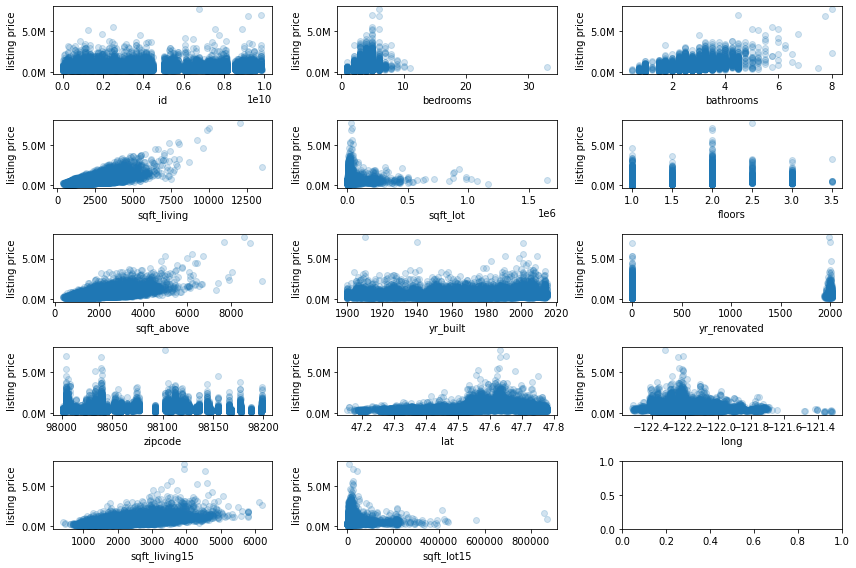

In [27]:
fig, axes = plt.subplots(ncols=3, nrows=5, figsize=(12, 8))
fig.set_tight_layout(True)

for index, col in enumerate(X_train_numeric.columns):
    ax = axes[index//3][index%3]
    ax.yaxis.set_major_formatter(formatter)
    ax.scatter(X_train_numeric[col], Y_train, alpha=0.2)
    ax.set_xlabel(col)
    ax.set_ylabel("listing price")

In [189]:
X_train_second_model = X_train_numeric.drop(["id", "zipcode", "yr_renovated"], axis=1).copy()
X_train_second_model

,bedrooms,bathrooms,sqft_living,sqft_lot,floors,sqft_above,yr_built,lat,long,sqft_living15,sqft_lot15
0,3,1.00,1180,5650,1.0,1180,1955,47.5112,-122.257,1340,5650
1,3,2.25,2570,7242,2.0,2170,1951,47.7210,-122.319,1690,7639
2,2,1.00,770,10000,1.0,770,1933,47.7379,-122.233,2720,8062
3,4,3.00,1960,5000,1.0,1050,1965,47.5208,-122.393,1360,5000
4,3,2.00,1680,8080,1.0,1680,1987,47.6168,-122.045,1800,7503
...,...,...,...,...,...,...,...,...,...,...,...
21592,3,2.50,1530,1131,3.0,1530,2009,47.6993,-122.346,1530,1509
21593,4,2.50,2310,5813,2.0,2310,2014,47.5107,-122.362,1830,7200
21594,2,0.75,1020,1350,2.0,1020,2009,47.5944,-122.299,1020,2007
21595,3,2.50,1600,2388,2.0,1600,2004,47.5345,-122.069,1410,1287


In [190]:
second_model = LinearRegression()

second_model_scores = cross_validate(
    estimator=second_model,
    X=X_train_second_model,
    y=Y_train,
    return_train_score=True,
    cv=splitter
)

print("Current Model")
print("Train score:     ", second_model_scores["train_score"].mean())
print("Validation score:", second_model_scores["test_score"].mean())
print()
print("Baseline Model")
print("Train score:     ", baseline_scores["train_score"].mean())
print("Validation score:", baseline_scores["test_score"].mean())

Current Model
Train score:      0.6202941269981114
Validation score: 0.6266303983850896

Baseline Model
Train score:      0.48774659364870426
Validation score: 0.5024006604207555


In [191]:
sm.OLS(Y_train, sm.add_constant(X_train_second_model)).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.623
Model:                            OLS   Adj. R-squared:                  0.622
Method:                 Least Squares   F-statistic:                     3237.
Date:                Tue, 16 Nov 2021   Prob (F-statistic):               0.00
Time:                        15:03:04   Log-Likelihood:            -2.9687e+05
No. Observations:               21597   AIC:                         5.938e+05
Df Residuals:                   21585   BIC:                         5.939e+05
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const         -5.387e+07   1.72e+06    -31.286      0.000   -5.72e+07   -5.05e+07
bedrooms      -5.684e+04   2091.762    -27.171      0.000   -6.09e+04   -5.27e+04
bathrooms      6.398e+04   3613.376     17.705      0.000    5.69e+04    7.11e+04
sqft_living     222.1521      4.745     46.818      0.000     212.851     231.453
sqft_lot          0.1891      0.054      3.522      0.000       0.084       0.294
floors          1.98e+04   3986.183      4.968      0.000     1.2e+04    2.76e+04
sqft_above       32.5898      4.764      6.841      0.000      23.252      41.928
yr_built      -2456.4936     71.267    -34.469      0.000   -2596.182   -2316.805
lat            5.843e+05   1.15e+04     50.693      0.000    5.62e+05    6.07e+05
long           -2.52e+05   1.31e+04    -19.229      0.000   -2.78e+05   -2.26e+05
sqft_living15    92.0555      3.620     25.431      0.000      84.960      99.151
sqft_lot15       -0.4069      0.082     -4.949      0.000      -0.568      -0.246
==============================================================================
Omnibus:                    17547.609   Durbin-Watson:                   1.997
Prob(Omnibus):                  0.000   Jarque-Bera (JB):          1156114.601
Skew:                           3.454   Prob(JB):                         0.00
Kurtosis:                      38.172   Cond. No.                     5.67e+07
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 5.67e+07. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [192]:
# Importances are based on coefficient magnitude, so
# we need to scale the data to normalize the coefficients
X_train_for_RFECV = StandardScaler().fit_transform(X_train_second_model)

model_for_RFECV = LinearRegression()

# Instantiate and fit the selector
selector = RFECV(model_for_RFECV, cv=splitter)
selector.fit(X_train_for_RFECV, Y_train)

# Print the results
print("Was the column selected?")
for index, col in enumerate(X_train_second_model.columns):
    print(f"{col}: {selector.support_[index]}")

Was the column selected?
bedrooms: True
bathrooms: True
sqft_living: True
sqft_lot: True
floors: True
sqft_above: True
yr_built: True
lat: True
long: True
sqft_living15: True
sqft_lot15: True


In [193]:
#final_model = LinearRegression()

# Fit the model on X_train_final and y_train
#final_model.fit(X_train_second_model, Y_train)

# Score the model on X_test_final and y_test
# (use the built-in .score method)
#final_model.score(X_test, Y_test)